In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skew_correction.data import DatasetClass, MyDataModule, plot_random_images
from skew_correction.model import MyModelModule, TimmClassifier, total_params
from skew_correction.constants import root_dir, device
from skew_correction.train_utils import checkpoint_callback, early_stop_callback

import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
from pytz import timezone  # This library helps you get the timezone if needed

/home/deepam_minda_farmart_co/anaconda3/envs/temp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device

device(type='cuda')

## data

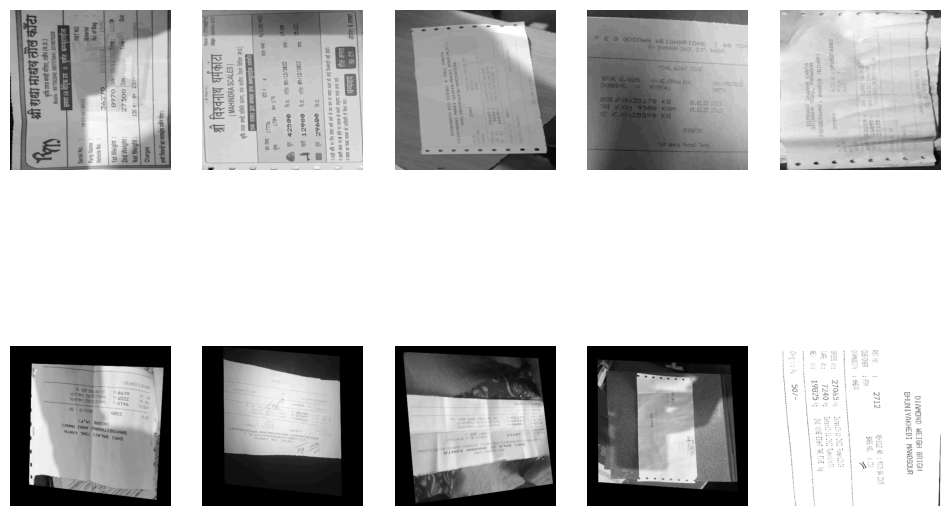

In [4]:
## load dataset
dataset = DatasetClass("/home/deepam_minda_farmart_co/fmt/skew_correction/data/train_data.csv", split='train')
plot_random_images(dataset)
pl_data = MyDataModule(dataset, train_bs=16, val_bs=8)

In [5]:
## check data sizes
pl_data.setup()
tdl = pl_data.train_dataloader()
vdl = pl_data.val_dataloader()
print(f"len of dataloader = {len(tdl)}, batchsize = {tdl.batch_size} \ntotal samples = {len(tdl)*tdl.batch_size}")
print(f"len of dataloader = {len(vdl)}, batchsize = {vdl.batch_size} \ntotal samples = {len(vdl)*vdl.batch_size}")

len of dataloader = 22, batchsize = 16 
total samples = 352
len of dataloader = 11, batchsize = 8 
total samples = 88


## train


In [6]:
import timm 
timm.list_models("mobile*")
model = timm.create_model("mobilenetv3_large_100")
total_params(model)
# 

5483032

In [8]:
## load model

lr = 0.0001
loss_fn = torch.nn.CrossEntropyLoss()

model_string = 'mobilenetv3_large_100'
dropout=0.3
model = TimmClassifier(model_string, dropout=dropout)
print(f"total_params: {total_params(model)}")

pl_model = MyModelModule(model, loss_fn, lr)


total_params: 4206868


In [9]:
verbose=False

# Get the current date and time in a specific format
current_date = datetime.now(timezone('Asia/Kolkata')).strftime('%Y-%m-%d')

tb_logger = TensorBoardLogger(
    save_dir=os.path.join(root_dir, 'logs'), 
    name=f"{current_date}-{model_string}-{round(total_params(model)/1000000,2)}m_params-{len(tdl)*tdl.batch_size}samples-lr{lr}-bs{tdl.batch_size}-cpu-drop{dropout}"
)
print(tb_logger.name)
trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        max_epochs=50, 
        logger=tb_logger, 
        log_every_n_steps=1, 
        limit_train_batches=None, 
        limit_val_batches=None,
        enable_checkpointing=True,
        callbacks=[checkpoint_callback, early_stop_callback],
    )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2023-07-31-mobilenetv3_large_100-4.21m_params-352samples-lr0.0003-bs16-cpu-drop0.3


In [10]:
trainer.fit(pl_model, datamodule=pl_data)

# pl_model.trainer.callback_metrics

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | TimmClassifier   | 4.2 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.827    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]==========> Epoch 0
{'val_loss': 4.69, 'val_acc': 0.19, 'val_acc_epoch': 0.19}
Epoch 0: 100%|██████████| 33/33 [00:15<00:00,  2.17it/s, loss=2.17, v_num=1]==========> Epoch 0
{'train_loss': 1.19, 'train_acc': 0.67, 'train_acc_step': 0.67, 'val_loss': 1.52, 'val_acc': 0.49, 'val_acc_epoch': 0.49}
Epoch 0: 100%|██████████| 33/33 [00:15<00:00,  2.17it/s, loss=2.17, v_num=1]

Metric val_loss improved. New best score: 1.521


Epoch 1: 100%|██████████| 33/33 [00:29<00:00,  1.10it/s, loss=0.821, v_num=1]==========> Epoch 1
{
    "train_loss": 0.42,
    "train_acc_epoch": 0.42,
    "val_loss": 1.47,
    "val_acc_epoch": 0.53
}
Epoch 1: 100%|██████████| 33/33 [00:29<00:00,  1.10it/s, loss=0.821, v_num=1]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.469


Epoch 2: 100%|██████████| 33/33 [00:43<00:00,  1.33s/it, loss=0.439, v_num=1]==========> Epoch 2
{
    "train_loss": 0.19,
    "train_acc_epoch": 0.75,
    "val_loss": 2.77,
    "val_acc_epoch": 0.51
}
Epoch 3: 100%|██████████| 33/33 [00:57<00:00,  1.75s/it, loss=0.524, v_num=1]==========> Epoch 3
{
    "train_loss": 0.06,
    "train_acc_epoch": 0.86,
    "val_loss": 1.81,
    "val_acc_epoch": 0.59
}
Epoch 4: 100%|██████████| 33/33 [01:11<00:00,  2.16s/it, loss=0.56, v_num=1] ==========> Epoch 4
{
    "train_loss": 0.29,
    "train_acc_epoch": 0.82,
    "val_loss": 1.28,
    "val_acc_epoch": 0.72
}
Epoch 4: 100%|██████████| 33/33 [01:11<00:00,  2.16s/it, loss=0.56, v_num=1]

Metric val_loss improved by 0.188 >= min_delta = 0.0. New best score: 1.281


Epoch 5: 100%|██████████| 33/33 [01:25<00:00,  2.59s/it, loss=0.337, v_num=1]==========> Epoch 5
{
    "train_loss": 0.54,
    "train_acc_epoch": 0.84,
    "val_loss": 1.42,
    "val_acc_epoch": 0.7
}
Epoch 6: 100%|██████████| 33/33 [01:39<00:00,  3.02s/it, loss=0.387, v_num=1]==========> Epoch 6
{
    "train_loss": 0.03,
    "train_acc_epoch": 0.89,
    "val_loss": 0.63,
    "val_acc_epoch": 0.86
}
Epoch 6: 100%|██████████| 33/33 [01:39<00:00,  3.02s/it, loss=0.387, v_num=1]

Metric val_loss improved by 0.647 >= min_delta = 0.0. New best score: 0.635


Epoch 7: 100%|██████████| 33/33 [01:54<00:00,  3.47s/it, loss=0.119, v_num=1] ==========> Epoch 7
{
    "train_loss": 0.65,
    "train_acc_epoch": 0.89,
    "val_loss": 0.52,
    "val_acc_epoch": 0.88
}
Epoch 7: 100%|██████████| 33/33 [01:54<00:00,  3.47s/it, loss=0.119, v_num=1]

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 0.522


Epoch 8: 100%|██████████| 33/33 [02:08<00:00,  3.90s/it, loss=0.122, v_num=1]  ==========> Epoch 8
{
    "train_loss": 0.12,
    "train_acc_epoch": 0.96,
    "val_loss": 0.78,
    "val_acc_epoch": 0.83
}
Epoch 9: 100%|██████████| 33/33 [02:23<00:00,  4.36s/it, loss=0.0821, v_num=1] ==========> Epoch 9
{
    "train_loss": 0.09,
    "train_acc_epoch": 0.97,
    "val_loss": 0.54,
    "val_acc_epoch": 0.89
}
Epoch 10: 100%|██████████| 33/33 [02:38<00:00,  4.79s/it, loss=0.0169, v_num=1]  ==========> Epoch 10
{
    "train_loss": 0.0,
    "train_acc_epoch": 0.97,
    "val_loss": 0.38,
    "val_acc_epoch": 0.93
}
Epoch 10: 100%|██████████| 33/33 [02:38<00:00,  4.79s/it, loss=0.0169, v_num=1]

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 0.382


Epoch 11: 100%|██████████| 33/33 [02:52<00:00,  5.22s/it, loss=0.0249, v_num=1]  ==========> Epoch 11
{
    "train_loss": 0.02,
    "train_acc_epoch": 1.0,
    "val_loss": 0.37,
    "val_acc_epoch": 0.9
}
Epoch 11: 100%|██████████| 33/33 [02:52<00:00,  5.22s/it, loss=0.0249, v_num=1]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.372


Epoch 12: 100%|██████████| 33/33 [03:06<00:00,  5.64s/it, loss=0.0181, v_num=1]  ==========> Epoch 12
{
    "train_loss": 0.0,
    "train_acc_epoch": 0.99,
    "val_loss": 0.44,
    "val_acc_epoch": 0.93
}
Epoch 13: 100%|██████████| 33/33 [03:20<00:00,  6.06s/it, loss=0.0127, v_num=1]  ==========> Epoch 13
{
    "train_loss": 0.02,
    "train_acc_epoch": 0.99,
    "val_loss": 0.54,
    "val_acc_epoch": 0.85
}
Epoch 14: 100%|██████████| 33/33 [03:34<00:00,  6.49s/it, loss=0.0256, v_num=1]  ==========> Epoch 14
{
    "train_loss": 0.0,
    "train_acc_epoch": 0.99,
    "val_loss": 0.31,
    "val_acc_epoch": 0.93
}
Epoch 14: 100%|██████████| 33/33 [03:34<00:00,  6.49s/it, loss=0.0256, v_num=1]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.306


Epoch 15: 100%|██████████| 33/33 [03:48<00:00,  6.93s/it, loss=0.017, v_num=1]   ==========> Epoch 15
{
    "train_loss": 0.0,
    "train_acc_epoch": 0.99,
    "val_loss": 0.6,
    "val_acc_epoch": 0.86
}
Epoch 16: 100%|██████████| 33/33 [04:03<00:00,  7.37s/it, loss=0.0122, v_num=1]  ==========> Epoch 16
{
    "train_loss": 0.0,
    "train_acc_epoch": 1.0,
    "val_loss": 0.54,
    "val_acc_epoch": 0.89
}
Epoch 17: 100%|██████████| 33/33 [04:17<00:00,  7.81s/it, loss=0.0131, v_num=1]  ==========> Epoch 17
{
    "train_loss": 0.0,
    "train_acc_epoch": 1.0,
    "val_loss": 0.65,
    "val_acc_epoch": 0.86
}
Epoch 18: 100%|██████████| 33/33 [04:31<00:00,  8.23s/it, loss=0.0181, v_num=1]   ==========> Epoch 18
{
    "train_loss": 0.0,
    "train_acc_epoch": 0.99,
    "val_loss": 0.43,
    "val_acc_epoch": 0.92
}
Epoch 19: 100%|██████████| 33/33 [04:45<00:00,  8.65s/it, loss=0.00109, v_num=1] ==========> Epoch 19
{
    "train_loss": 0.0,
    "train_acc_epoch": 0.99,
    "val_loss": 0.41,


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.306. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 33/33 [04:45<00:00,  8.65s/it, loss=0.00109, v_num=1]
